In [3856]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import ast 
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.api as sm
from sympy import symbols, integrate, lambdify, diff
import scipy.integrate as spi

### Histogram for Germination Frame Frequency

In [3857]:
def germination_frequency(plots_folder: str, GERMINATION: list, output: int = 1) -> None:
  '''
  output denotes whether to output produced dictionary and plot to jupyter notebooks, shown by default

  creates a dictionary with germination frames as a key, and frequency as a value
  these frequencies are printed in the function
  a histogram plot is also produced
  '''
  germination_frames_list = GERMINATION.apply(lambda x: x.index(1)) #list of germination frames as indices

  #print times frame germination occurs
  frame_counts = Counter(germination_frames_list)
  sorted_frame_counts = sorted(frame_counts.items())
  for frame_number, count in sorted_frame_counts:
      if output == 1:
        print(f"Frame: {frame_number}, Frequency: {count}")
      
  #histogram plot 
  plt.figure(figsize=(4, 3))
  plt.hist(germination_frames_list, bins=289, color='pink', edgecolor='black')
  plt.title("Germination Times")
  plt.xlabel("Frame Number")
  plt.ylabel("Frequency")
  plt.grid()
  plt.savefig(plots_folder + "germination_frequency.jpg")

  if output != 1:
    plt.close()
  return 

### Descriptive Statistics

Group together spores and create a boxplot at each timestep for all spores

In [3858]:
def group_by_germination(df, feature_str: list[str]):
  ''' 
  Takes in original data frame and list of features to analyze and group together
  returns grouped data
  '''
  data_stats = df.copy()

  for feature in feature_str:
    data_stats[feature] = data_stats[feature].apply(ast.literal_eval)

  data_stats['Germination Frame'] = data_stats['GERMINATION'].apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 
  grouped_data = data_stats.groupby("Germination Frame")

  return grouped_data, data_stats

In [3859]:
def get_min_max(df, feature: str) -> int:
    data_max = []
    data_min = []
    data = df[feature].apply(ast.literal_eval) 
    for row in data:
        data_max.append(max(row))
        data_min.append(min(row))
    return min(data_min), max(data_max)


def box_plot_statistics(germ_time, data, column: str, feature: str, y_minmax: [int, int], show_plot = 1):
    min_feature = y_minmax[0]
    max_feature = y_minmax[1]
    
    aligned_data = [pd.Series(data) for data in data[column]]
    aligned_df = pd.DataFrame(aligned_data)
    melted_aligned_df = aligned_df.melt(var_name='Frame', value_name=feature) #long format
    
    # plotting
    plt.figure(figsize=(4, 3))
    sns.boxplot(x='Frame', y=feature, data=melted_aligned_df)
    plt.axvline(x=germ_time, color='red', linestyle='--', label=f'Germination Frame {germ_time}')
    plt.title(f'{feature} Statistics for Spores Germinated at Frame {germ_time}')
    plt.xlabel('Frame')
    plt.xticks([0, 50, 100, 150, 200, 150, 200, 250])
    plt.ylabel(feature)
    plt.ylim([min_feature, max_feature])
    plt.legend()
    plt.savefig(f"{plots_folder}  {feature} _boxplot_ + {germ_time} .jpg")
    
    if show_plot != 1:
        plt.close()

### Spatial

In [3860]:
def plot_xy_germinationframe(df, show_plot = 1):  
  '''
  plots x and y location with germination frame as z value 
  '''
  plt.figure(figsize=(4, 3))
  #plot
  scatter = plt.scatter(df['X_POSITION'], df['Y_POSITION'], c = df['Germination Frame'], cmap = 'gist_ncar', edgecolor='black', s=100)
  plt.colorbar(scatter, label='Germination Frame')
  plt.xlabel('X')
  plt.ylabel('Y')

  plt.gca().invert_yaxis()
  plt.title('Spores by Germination Frame')
  plt.grid(True)
  plt.savefig(f"{plots_folder}germinationframe_location.jpg")

  if show_plot != 1:
    plt.close()
  ###VALIDATE THIS overlay on tiff

### Signal Summation

In [3861]:
def total_signal(df, INTENSITY, GERMINATION):
  '''
  sums all intensities until germination and plots frame as x value and total sum as y 
  '''
  germination_totalintensity = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  for i in range(len(df)):
    spore_intensities = INTENSITY[i]
    spore_germination_frame = df.loc[i, "Germination Frame"] 
    intensities_before_germination = spore_intensities[0: spore_germination_frame]
    total_intensity = np.sum(intensities_before_germination)
    germination_totalintensity.append(np.array([spore_germination_frame, total_intensity]))

  germination_totalintensity_np = np.array(germination_totalintensity)

  plt.figure(figsize=(4, 3))
  plt.scatter(germination_totalintensity_np[:, 0], germination_totalintensity_np[:, 1])
  plt.xlabel("Germination Frame")
  plt.ylabel("Sum Intensity")
  plt.show()
  plt.close()

### Feature value before germination

In [3862]:
def germinationframe_feature(df, FEATURE: list, GERMINATION: list):
  '''
  takes in a FEATURE and GERMINATION and returns avg feature, initial value of feature, and last value of feature (all before germination)
  '''
  avg_germination_feature = []
  initial_germination_feature = []
  last_germination_feature = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  for i in range(len(df)):
    spore_feature = FEATURE[i]
    spore_germination_frame = df.loc[i, "Germination Frame"]
    feature_before_germination = spore_feature[0: spore_germination_frame]


    avg_feature = np.mean(feature_before_germination)
    initial_feature = np.mean(feature_before_germination[0: 5]) #averaged over first and last frames
    last_feature = np.mean(feature_before_germination[-5: -1])

    avg_germination_feature.append(np.array([spore_germination_frame, avg_feature]))
    initial_germination_feature.append(np.array([spore_germination_frame, initial_feature]))
    last_germination_feature.append(np.array([spore_germination_frame, last_feature]))

  return [np.array(avg_germination_feature), np.array(initial_germination_feature), np.array(last_germination_feature)]
####--------
def subplot_scatter(arrays, y_label, subplot_title, min_max):
    avg_array, initial_array, last_array = arrays

    fig, axs = plt.subplots(2, 4, figsize=(16, 8))


    # color palette
    subplot_ylabels = [f"Average {y_label}", f"Initial {y_label}", f"Last {y_label}", f"Difference in {y_label}"]
    palette = sns.color_palette("pastel", 5)

    # group germination frames for box plot
    group_frames = [range(0, 15), range(30, 40), range(60, 70), range(80, 90), range(100, 300)] # HARDCODED

    # difference between initial value and last value before germination 
    diff_array = avg_array.copy()
    diff_array[:, 1] = last_array[:, 1] - initial_array[:, 1]

    # scatter plots
    for i, array in enumerate([avg_array, initial_array, last_array, diff_array]):
        for j, frames in enumerate(group_frames):
            group_indices = [frame_index for frame_index, germination_frame in enumerate(array[:, 0]) if germination_frame in frames]
            axs[0, i].scatter(array[group_indices, 0], array[group_indices, 1], color=palette[j], label=f'Frames {frames[0]} - {frames[-1]}')
        axs[0, i].set_title(subplot_ylabels[i])
        axs[0, i].set_ylabel(f"{subplot_title} before Germination")
        axs[0, i].set_ylim(min_max)
        axs[1, i].set_ylim(min_max)
        axs[0, i].legend()

    # y axis limits for difference plot 
    axs[0, 3].set_ylim([min(diff_array[:, 1]), max(diff_array[:, 1])])
    axs[1, 3].set_ylim([min(diff_array[:, 1]), max(diff_array[:, 1])])

    # box plots by frame groups
    arrays = [avg_array, initial_array, last_array, diff_array]

    for array_index, array in enumerate(arrays):
        df_list = []
        for frame_index, frames in enumerate(group_frames):
            spore_values = [array[row_index, 1] for row_index, row in enumerate(array) if array[row_index, 0] in frames]
            df_list.append(pd.DataFrame({f'{frames[0]} - {frames[-1]}': spore_values}))

        boxplot_data = pd.concat(df_list, axis=1)
        sns.boxplot(data=boxplot_data, ax=axs[1, array_index], palette=palette, width=0.5)

    plt.tight_layout()
    plt.show()

    return diff_array
    #heat map between initial and difference 
    

In [3863]:
def intensity_area_ratio(df, INTENSITY, AREA):
  '''
  get intensity over all frames divided by area
  return df of ratios
  '''
  
  if isinstance(AREA, pd.Series):
    INTENSITY = INTENSITY.to_list()
    AREA = AREA.to_list()
    
  if isinstance(AREA, pd.DataFrame):
    AREA = AREA.values.tolist()

  
  RATIOS = []
  for spore_index in range(len(INTENSITY)):
    spore_intensity = INTENSITY[spore_index]
    spore_area = AREA[spore_index]

    # if passing pd.dataframe insteaed of series
    if len(spore_area) == 1:
      spore_area = spore_area[0]

    spore_ratios = []
    for frame_index in range(len(INTENSITY[spore_index])):
      ratio = spore_intensity[frame_index]/spore_area[frame_index]
      spore_ratios.append(ratio)
    RATIOS.append(spore_ratios)  
  return pd.DataFrame(RATIOS)

### Fitting a Linear Model to each spore

In [3864]:
def polynomial_model(x, *coefficients):
    summ = 0
    for index, coefficient in enumerate(coefficients):
        summ += coefficient * x ** index
    return summ

def fit_polynomial_model(df, INTENSITY, GERMINATION, yaxis, degree, show_plots=1):
    df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1))
    INTENSITY_LIST = INTENSITY.to_list()

    df["INTEGRAL"] = None
    df["DERIVATIVE"] = None

    grouped = df.groupby('Germination Frame')
    for germination_frame, group in grouped:
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))  
        sns.set_palette("pastel")

        for spore_index in group.index:
            intensities = INTENSITY_LIST[spore_index]
            frames = list(range(len(intensities)))

            frames_until_germination = list(range(germination_frame + 1))
            intensity_until_germination = intensities[:germination_frame + 1]

            # fitting
            initial_guess = [1] * (degree + 1)
            polynomial_lambda = lambda x, *params: polynomial_model(x, *params)
            parameters_allframes, _ = curve_fit(polynomial_lambda, frames, intensities, p0=initial_guess)

            polynomial_lambda_until_germination = lambda x, *params: polynomial_model(x, *params)
            parameters_untilgermination, _ = curve_fit(polynomial_lambda_until_germination, frames_until_germination, intensity_until_germination, p0=initial_guess)

            fitted_line_values = np.array([frames, polynomial_model(np.array(frames), *parameters_allframes)])
            fitted_line_values_until_germination = np.array([frames_until_germination, polynomial_model(np.array(frames_until_germination), *parameters_untilgermination)])

            #get derivative up to and including germinaiton frame
            derivatives = []
            integrals = []
            for frame in frames_until_germination:
                derivative_fcn = derivative_function(parameters_untilgermination)
                derivative_at_frame = derivative_fcn(frame)
                derivatives.append(derivative_at_frame)
            df.loc[spore_index, "DERIVATIVE"] = str(derivatives)

            #integral up to germination frame
            for frame in frames_until_germination[0: -1]:
                integral_fcn = integral_function(parameters_untilgermination)
                integral_at_frame = integral_fcn(frame) - integral_fcn(0)#? 
                integrals.append(integral_at_frame)       
            df.loc[spore_index, "INTEGRAL"] = str(integrals)         
            
            # plotting fitted line 
            sns.lineplot(ax = axs[0], x=frames, y=intensities, color="lightgrey")#, label="Data", linewidth=1)
            #sns.lineplot(x=fitted_line_values[0, :], y=fitted_line_values[1, :], label='Fitted to all data')
            sns.lineplot(ax = axs[0], x=fitted_line_values_until_germination[0, :], y=fitted_line_values_until_germination[1, :])#, label='Fitted until germination frame + 1')
            axs[0].axvline(germination_frame, color="black", linestyle="--")#, label="Germination")
            
            #plotting derivative
            sns.lineplot(ax = axs[1], x = frames_until_germination, y = derivatives)
            axs[1].axvline(germination_frame, color="black", linestyle="--")#, label="Germination")

            #plotting integral
            sns.lineplot(ax = axs[2], x = frames_until_germination[0: -1], y = integrals)


        axs[0].set_xlabel('Frames')
        axs[0].set_ylabel('Intensity')
        axs[0].set_ylim(yaxis)
        axs[0].set_title(f'Fitted Polynomials of Degree {degree} for Germination Frame {germination_frame}')
        
        axs[1].set_xlabel('Frames')
        axs[1].set_xlim([0, len(INTENSITY[0])])
        axs[1].set_ylabel("Intensity Derivative")
        axs[1].set_ylim([-5, 25])
        axs[1].set_title(f'Derivatives of Polynomials for Germination Frame {germination_frame}')

        axs[2].set_xlim([0, len(INTENSITY[0])]) 
        axs[2].set_ylim([0, 3000])
        plt.tight_layout()

    if show_plots != 1:
        plt.close()
    if show_plots == 1:
        plt.show()

    return df

def integral_function(parameters):
    # polynomial expression as symbolic variable
    x = symbols('x')
    polynomial_expr = sum(p * x**i for i, p in enumerate(parameters))

    # integrate
    integral_expr = integrate(polynomial_expr, x)

    # integral in [0, germintaion_frame]
    integral_func = lambdify(x, integral_expr, 'numpy')
    return integral_func

def derivative_function(parameters):
    x = symbols("x")
    polynomial_expr = sum(p * x**i for i, p in enumerate(parameters))
    derivative_expr = diff(polynomial_expr, x)
    derivative_func = lambdify(x, derivative_expr, 'numpy')
    return derivative_func

### Ordinary Least Squares

In [3865]:
def fit_ols_model(df, INTENSITY, GERMINATION, yaxis, show_plots=1):
    # Determine the germination frame for each entry
    df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1))
    INTENSITY_LIST = INTENSITY.to_list()

    # Group by germination frame
    grouped = df.groupby('Germination Frame')
    slopes_list = []
    for germination_frame, group in grouped:
        plt.figure(figsize=(12, 4))  # Create a new figure for each unique germination frame
        sns.set_palette("pastel")
        slopes = []
        for spore_index in group.index:
            intensities = np.array(INTENSITY_LIST[spore_index])
            frames = np.array(list(range(len(intensities))))

            frames_until_germination = np.array(list(range(germination_frame)))
            intensity_until_germination = np.array(intensities[:germination_frame])

            # Fit OLS model
            x_ols = sm.add_constant(frames_until_germination)
            ols_model = sm.OLS(intensity_until_germination, x_ols).fit()
            y_ols_pred = ols_model.predict(x_ols)
            slope = ols_model.params[1]

            slopes.append(slope) #to average slopes at each germiantion frame
            slopes_list.append([germination_frame, slope]) # to return all slopes

            # Plot the actual intensities and the OLS fit
            sns.lineplot(x = frames, y = intensities, color = "lightgrey")
            sns.lineplot(x = frames_until_germination, y = y_ols_pred)
        plt.xlabel('Frames')
        plt.ylabel('Intensity')
        plt.ylim(yaxis)
        plt.title(f'Germination Frame: {germination_frame}')
        plt.annotate(f'Average Slope: {np.mean(slopes):.2f}', xy = (0, yaxis[1] - 10))
        if show_plots != 1:
            plt.close()
    plt.clf()
    return np.array(slopes_list)

### Heatmap

In [3866]:
def heatmap(df, arrays, DIFF, feature, show_plots = 1):
    AVG, INITIAL, LAST = arrays
    germination_frames = list(AVG[:, 0])
    avg = list(AVG[:, 1])
    initial = list(INITIAL[:, 1])
    last = list(LAST[:, 1])
    diff = list(DIFF[:, 1])
    
    df = pd.DataFrame({
        "Germination Frame": germination_frames,
        f"Average": avg,
        f"Initial": initial, 
        f"Last": last,
        f"Difference": diff
    })

    correlation = df.corr()
    
    # plot heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(correlation, annot=True, vmin=-1, vmax=1)
    plt.title(f"{feature} Correlation before Germination")
    if show_plots == 1:
        plt.show()

    if show_plots != 1:
        plt.close()
    plt.clf()
    

In [3867]:
def plain_heatmap(values, plot_title):
  '''one numpy array wjere left column is germianiton frame and right column are single values'''
  frames = values[:, 0]
  value = values[:, 1]
  df = pd.DataFrame({
    "Germination Frame": frames, 
    f"{plot_title}": value})
  correlation = df.corr()
  sns.heatmap(correlation)
  plt.title(plot_title)
  plt.show()

### Main 

In [3868]:
def Main(csv_path, plots_folder, time_between_frames):
  df = pd.read_csv(csv_path)
  print(f"data has columns {list(df.columns)}...")

  # turning model data into lists
  INTENSITY: list[list] = df["INTENSITY"].apply(ast.literal_eval) 
  AREA: list[list] = df["AREA"].apply(ast.literal_eval)
  GERMINATION: list[list] = df["GERMINATION"].apply(ast.literal_eval)
  ELLIPSE_MINOR: list[list] = df["ELLIPSE MINOR"].apply(ast.literal_eval)
  ELLIPSE_MAJOR: list[list] = df["ELLIPSE MAJOR"].apply(ast.literal_eval)
  PERIMETER: list[list] = df["PERIMETER"].apply(ast.literal_eval)
  CIRCULARITY: list[int] = df["CIRCULARITY"].apply(ast.literal_eval)

  # germination frequency 
  germination_frequency(plots_folder, GERMINATION)

  # group data by germination frame
  groups, data_stats = group_by_germination(df, ["INTENSITY", "AREA", "GERMINATION"])

  # used for plot limits 
  min_intensity, max_intensity = get_min_max(df, "INTENSITY")
  min_area, max_area = get_min_max(df, "AREA")
  min_ellipse_minor, max_ellipse_minor = get_min_max(df, "ELLIPSE MINOR")
  min_perimeter, max_perimeter = get_min_max(df, "PERIMETER")
  min_circularity, max_circularity = get_min_max(df, "CIRCULARITY")

  # box plots for intensity and area at each timestep 
  #for name, group in groups: # name is germination frames, and groups is data 
    #box_plot_statistics(name, group, "INTENSITY", "Intensity", [min_intensity, max_intensity])
    #box_plot_statistics(name, group, "AREA", "Area", [min_area, max_area])

  #plot x, y, and germination frame  
  plot_xy_germinationframe(data_stats)  


  #---------------------feature boxplots 

  #intensity
  intensity_arrays = germinationframe_feature(df, INTENSITY, GERMINATION)
  diff_intensity = subplot_scatter(intensity_arrays, "Intensity", "Intensity", [min_intensity, max_intensity])

  #plot measure of area 
  area_arrays = germinationframe_feature(df, AREA, GERMINATION) 
  diff_area = subplot_scatter(area_arrays, "Area", "Area", [min_area, max_area])

  # plot measure of ellipse minors 
  minor_arrays = germinationframe_feature(df, ELLIPSE_MINOR, GERMINATION)
  diff_minor = subplot_scatter(minor_arrays, "Ellipse Minor", "Ellipse Minor", [min_ellipse_minor, max_ellipse_minor])

  # intensity/area
  INTENSITY_AREA_RATIO = intensity_area_ratio(df, INTENSITY, AREA)
  intensity_area_ratio_arrays = germinationframe_feature(df, INTENSITY_AREA_RATIO, GERMINATION)
  diff_ratio = subplot_scatter(intensity_area_ratio_arrays, "Ratio", "Intensity/Area", [0.09, 0.15])

  #major/minor
  MAJOR_MINOR_RATIO = intensity_area_ratio(df, ELLIPSE_MINOR, ELLIPSE_MAJOR)
  major_minor_ratio_arrays = germinationframe_feature(df, MAJOR_MINOR_RATIO, GERMINATION)
  diff_ellipseratio = subplot_scatter(major_minor_ratio_arrays, "Eccentricity", "Eccentricity", [.6, .9])

  #intensity/(ellipse ratio)
  df_ratio = MAJOR_MINOR_RATIO.apply(lambda row: row.tolist(), axis=1)
  df_ratio = pd.DataFrame(df_ratio.values)
  INTENSITY_ELLIPSE_RATIO = intensity_area_ratio(df, INTENSITY, df_ratio)
  intensity_ellipse_ratio_arrays = germinationframe_feature(df, INTENSITY_ELLIPSE_RATIO, GERMINATION)
  diff_intensity_ellipse_ratio = subplot_scatter(intensity_ellipse_ratio_arrays, "Intensity/Eccentricity", "Intensity/Eccentricity", [10,100])

  #perimeter
  perimeter_arrays = germinationframe_feature(df, PERIMETER, GERMINATION)
  diff_perim = subplot_scatter(perimeter_arrays, "Perimeter", "Perimeter", [min_perimeter, max_perimeter])

  #perimeter area ratio 
  PERIMETER_AREA_RATIO = intensity_area_ratio(df, PERIMETER, AREA)
  perimeter_area_ratio_arrays = germinationframe_feature(df, PERIMETER_AREA_RATIO, GERMINATION)
  diff_pa_ratio = subplot_scatter(perimeter_area_ratio_arrays, "Ratio", "Perimeter/Area Ratio", [0.175, 0.25])

  #circularity
  circularity_arrays = germinationframe_feature(df, CIRCULARITY, GERMINATION)
  diff_circularity = subplot_scatter(circularity_arrays, "Circularity", "Circularity", [min_circularity, max_circularity])
  
  #----------------------heatmap correlations
  heatmap(df, intensity_arrays, diff_intensity, "Intensity")
  heatmap(df, area_arrays, diff_area, "Area")
  heatmap(df, minor_arrays, diff_minor, "Ellipse Minor")
  heatmap(df, major_minor_ratio_arrays, diff_ellipseratio, "EllipseMinor/EllipseMajor")
  heatmap(df, intensity_area_ratio_arrays, diff_ratio, "Intensity/Area")
  heatmap(df, intensity_ellipse_ratio_arrays, diff_intensity_ellipse_ratio, "Intensity/Ellipse Ratio")
  heatmap(df, perimeter_arrays, diff_perim, "Perimeter")
  heatmap(df, perimeter_area_ratio_arrays, diff_pa_ratio, "Perimeter/Area")
  heatmap(df, circularity_arrays, diff_circularity, "Circularity")

  #plot scatter of total signal and germination frame
  total_signal(df, INTENSITY, GERMINATION)
  # total signal normalized by area 
  total_signal(df, INTENSITY_AREA_RATIO, GERMINATION)
  #total signal normalized by ellipse ratios
  total_signal(df, INTENSITY_ELLIPSE_RATIO, GERMINATION)

  #--------------------------- FITTING LINES 
  #fitting linear model to intensities with degree of last parameter input to function
  df_integrals = fit_polynomial_model(df, INTENSITY, GERMINATION, [min_intensity, max_intensity], 7, show_plots = 0)
  #ols line fit and printing slopes
  germination_slopes = fit_ols_model(df, INTENSITY, GERMINATION, [min_intensity, max_intensity], show_plots=0) #decrease as germination frame gets later
  plain_heatmap(germination_slopes, "OLS Slopes")


  #------------------ Integral derivative analysis 
  INTEGRAL: list[list] = df["INTEGRAL"].apply(ast.literal_eval) 
  DERIVATIVE : list[list] = df["DERIVATIVE"].apply(ast.literal_eval)

  min_integral, max_integral = get_min_max(df_integrals, "INTEGRAL")
  min_derivative, max_derivative = get_min_max(df_integrals, "DERIVATIVE")

  integral_arrays = germinationframe_feature(df_integrals, INTEGRAL, GERMINATION)
  diff_integral = subplot_scatter(integral_arrays, "Integral", "Integral", [min_integral, max_integral])
  diff_integral = subplot_scatter(integral_arrays, "Integral", "Integral", [25, 100])
'''FIX INTEGRALS'''
  

'FIX INTEGRALS'

data has columns ['Unnamed: 0', 'INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION', 'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', 'X_POSITION', 'Y_POSITION']...
Frame: 13, Frequency: 1
Frame: 14, Frequency: 4
Frame: 37, Frequency: 5
Frame: 38, Frequency: 20
Frame: 39, Frequency: 1
Frame: 61, Frequency: 3
Frame: 62, Frequency: 12
Frame: 63, Frequency: 2
Frame: 64, Frequency: 1
Frame: 86, Frequency: 4
Frame: 182, Frequency: 1


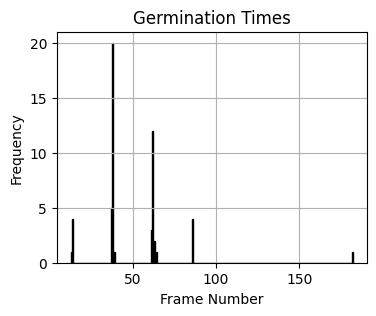

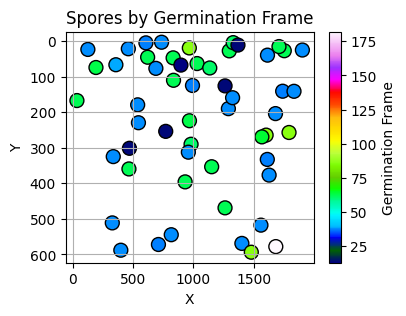

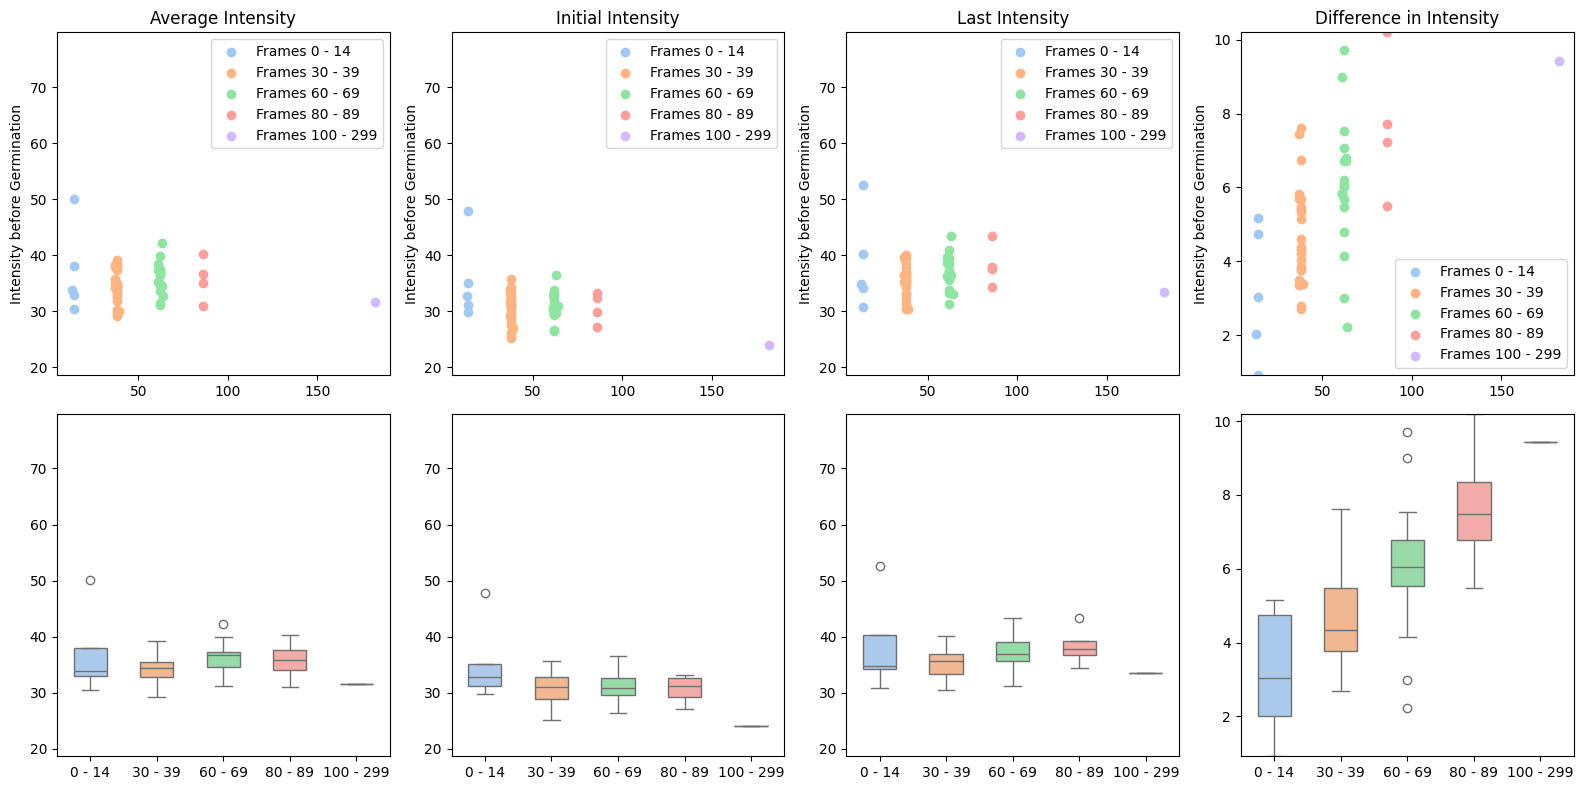

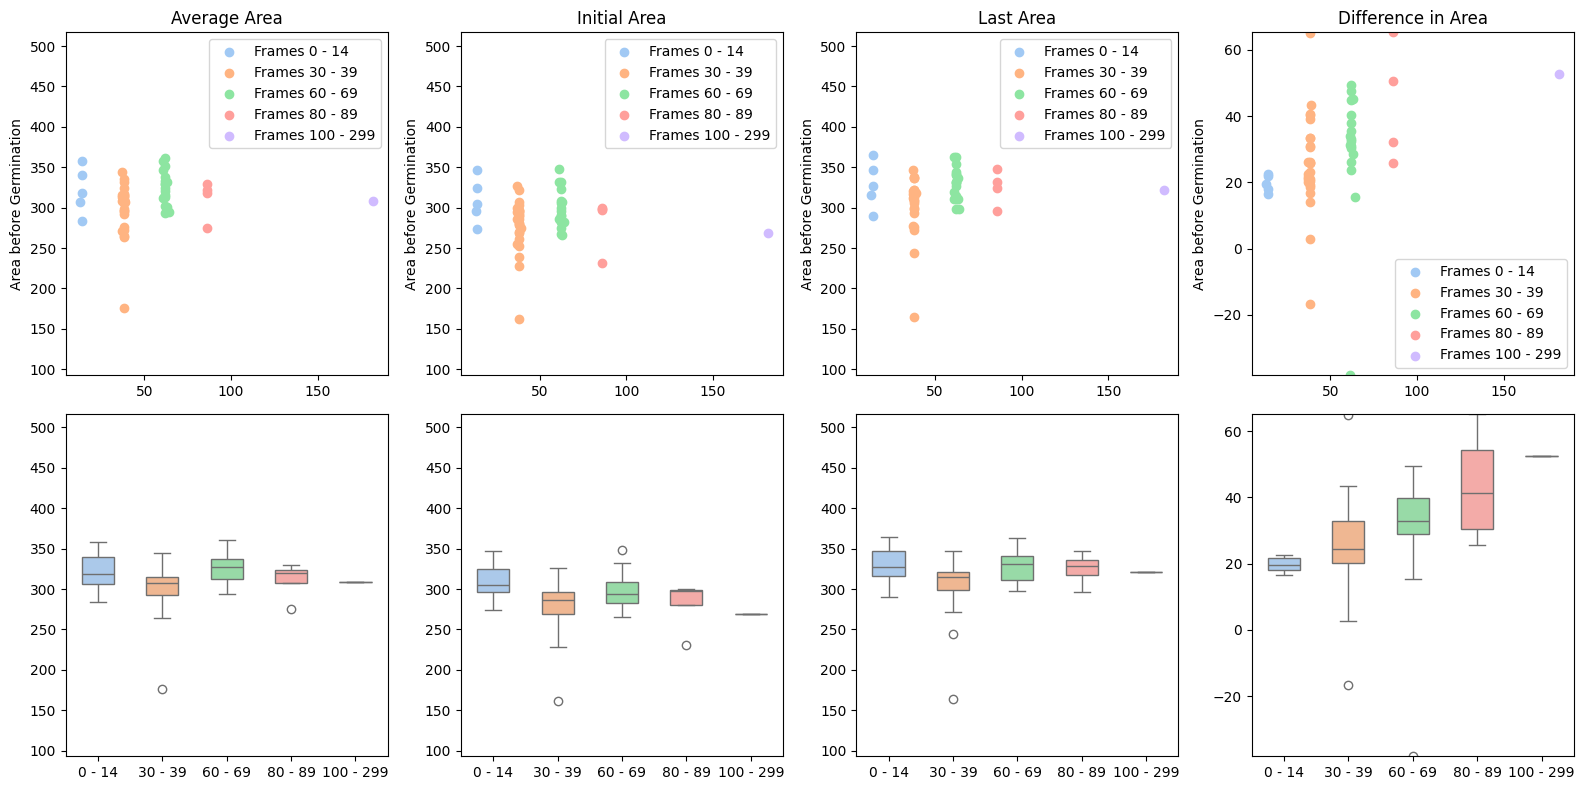

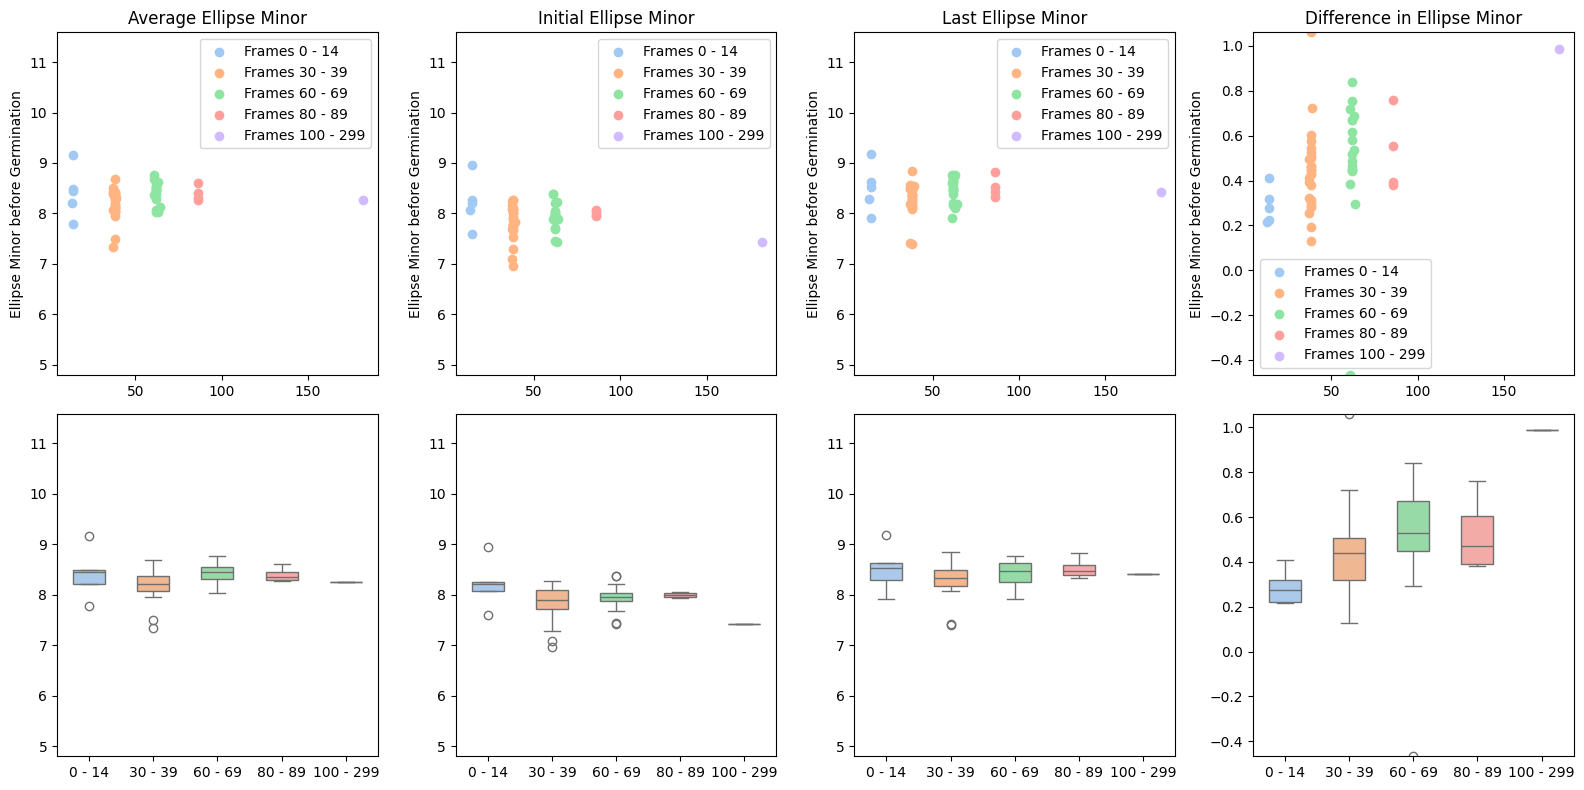

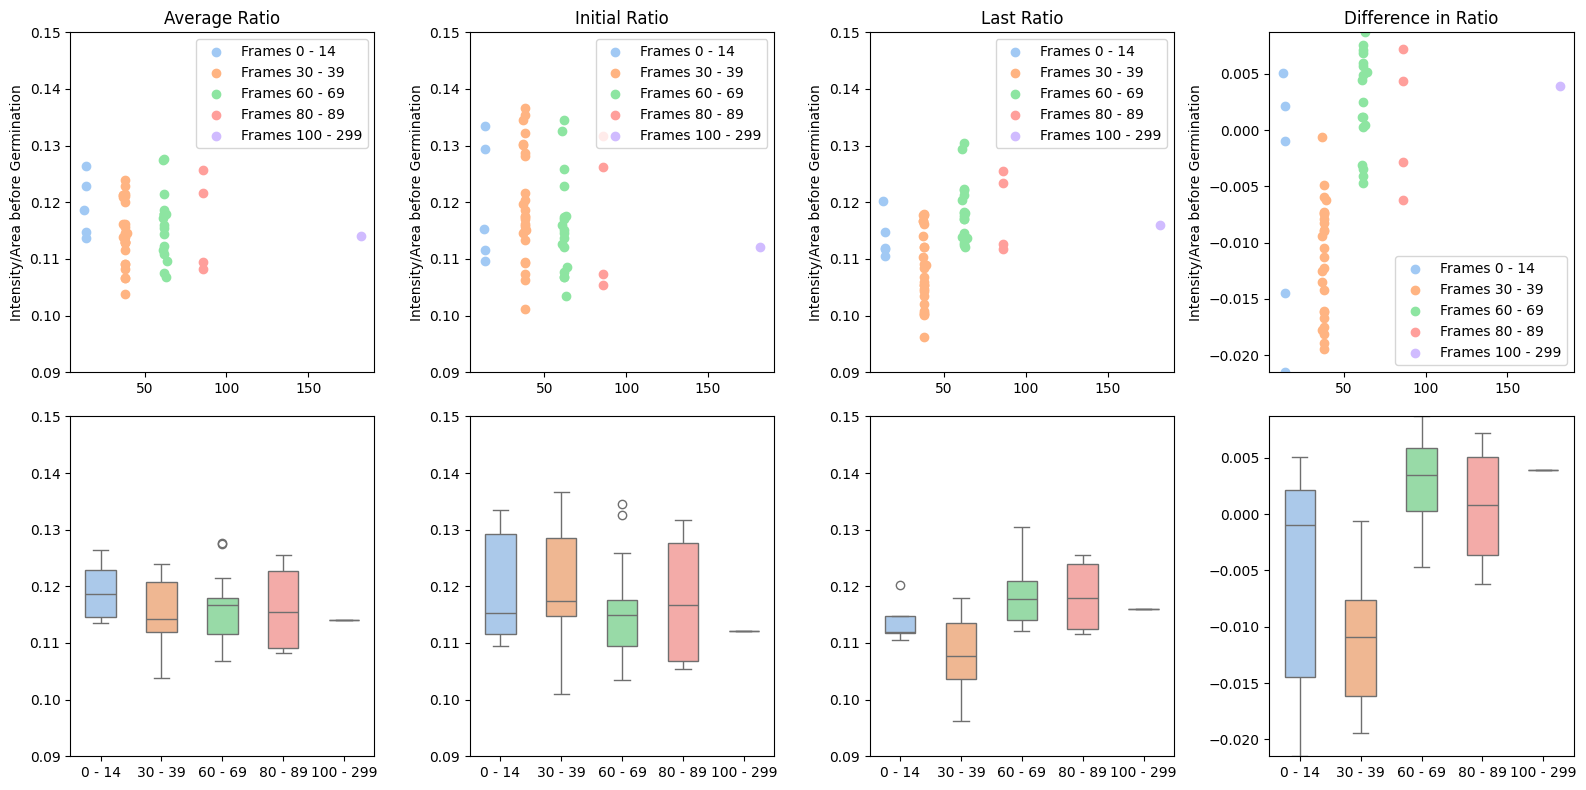

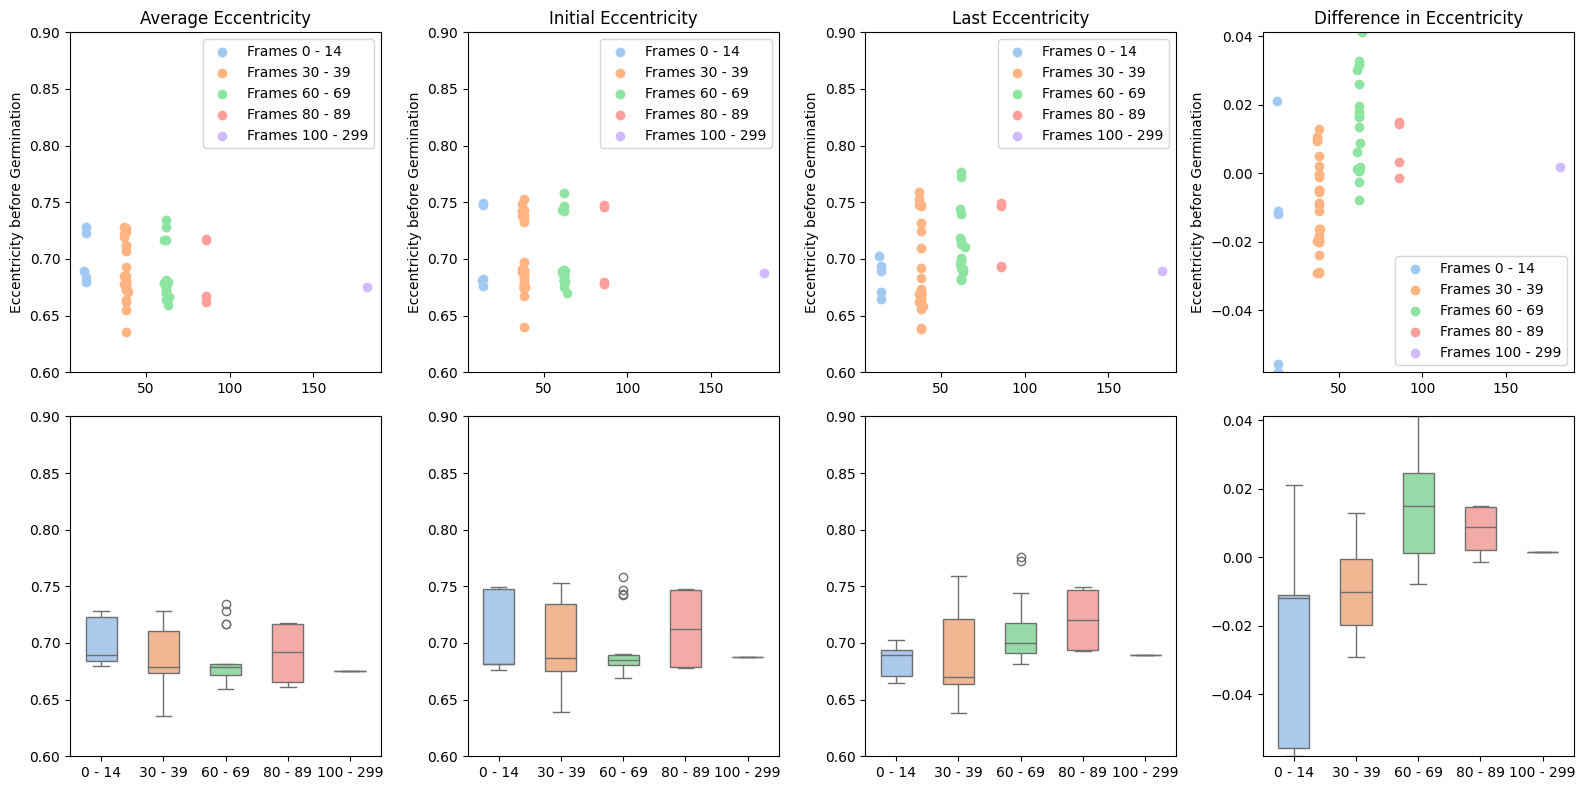

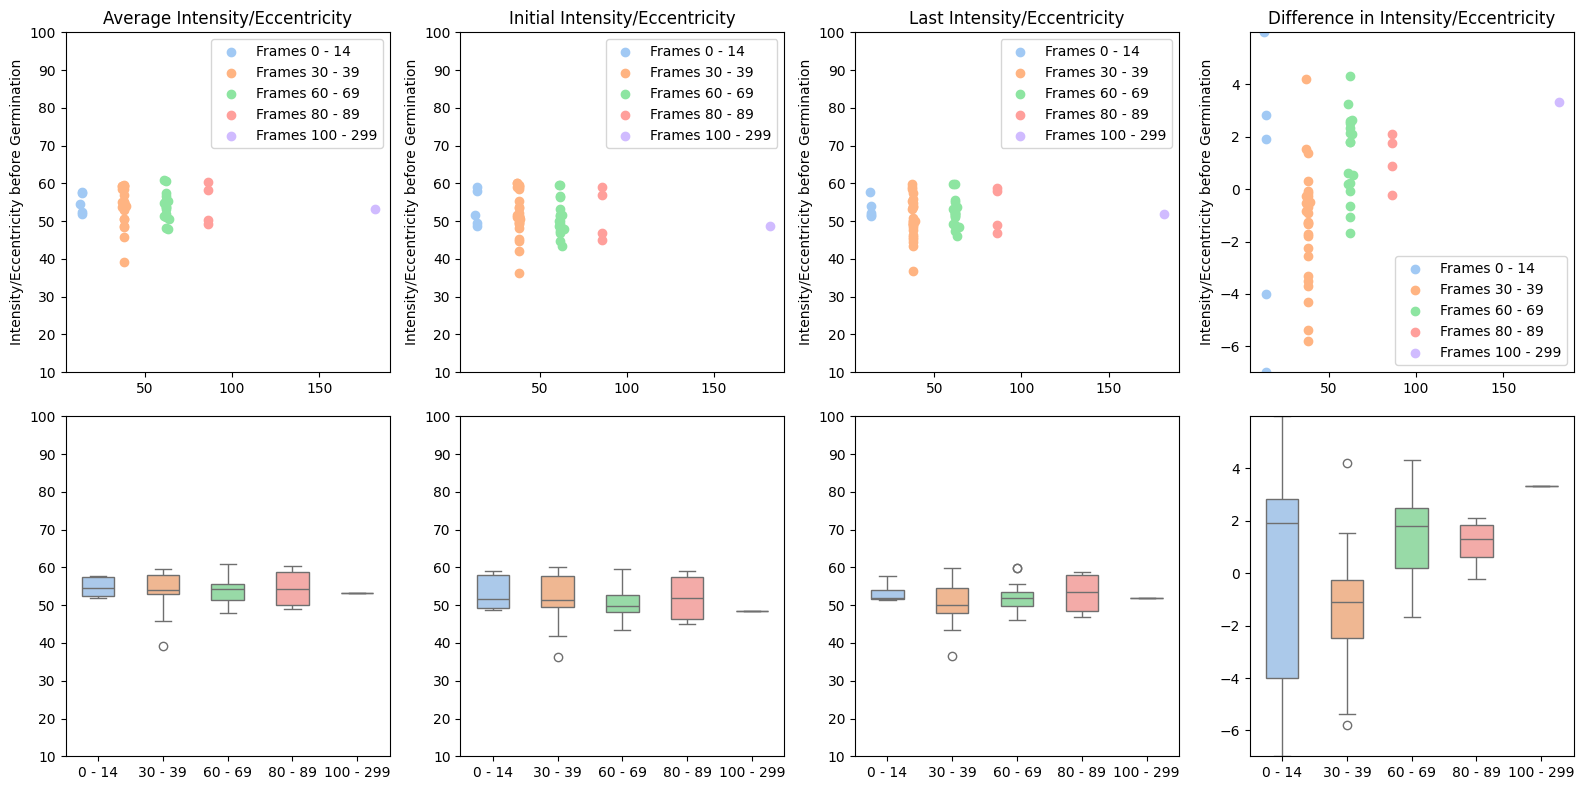

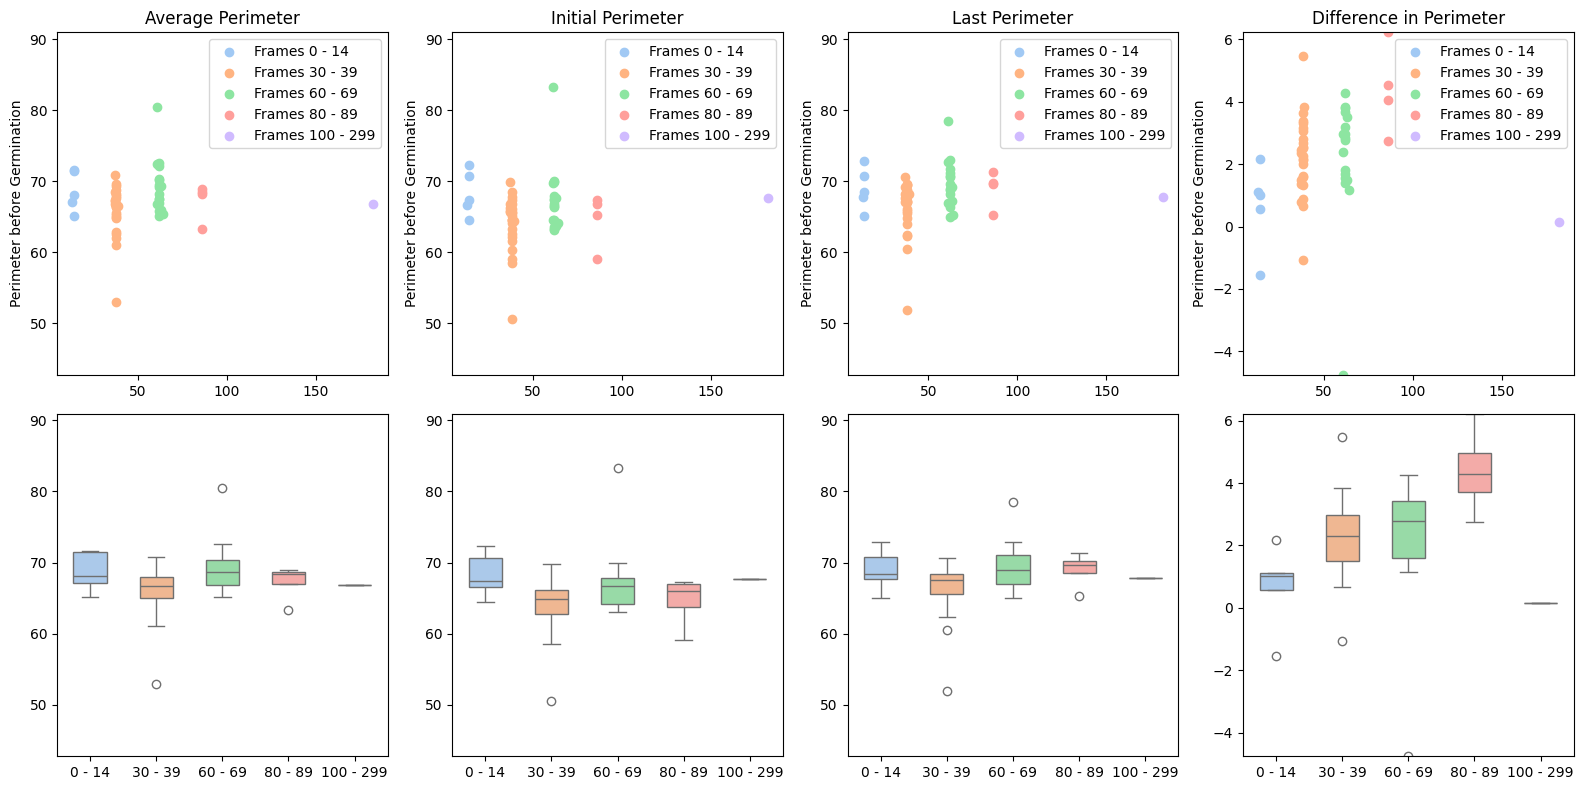

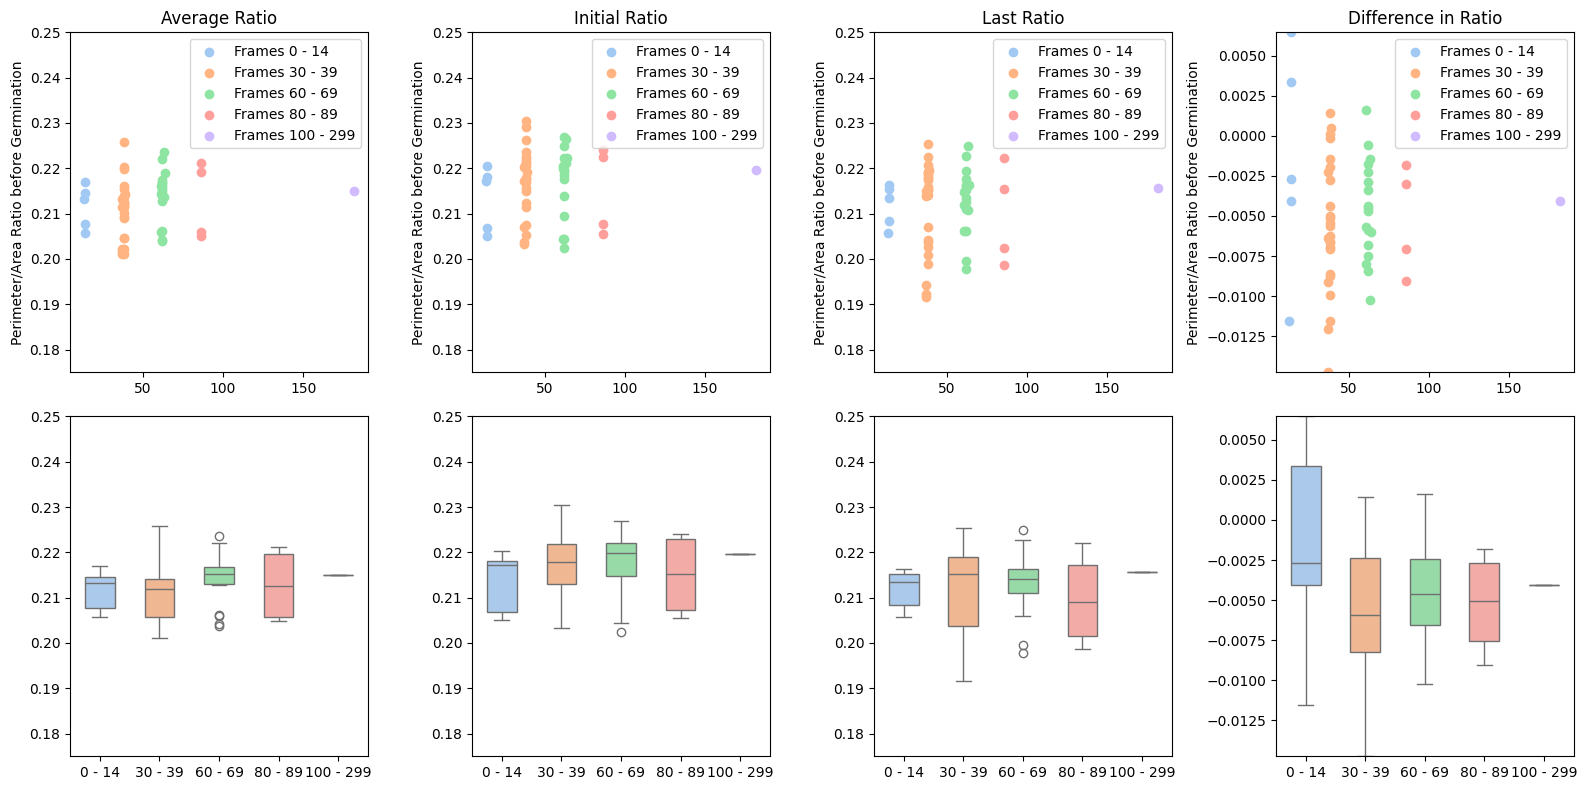

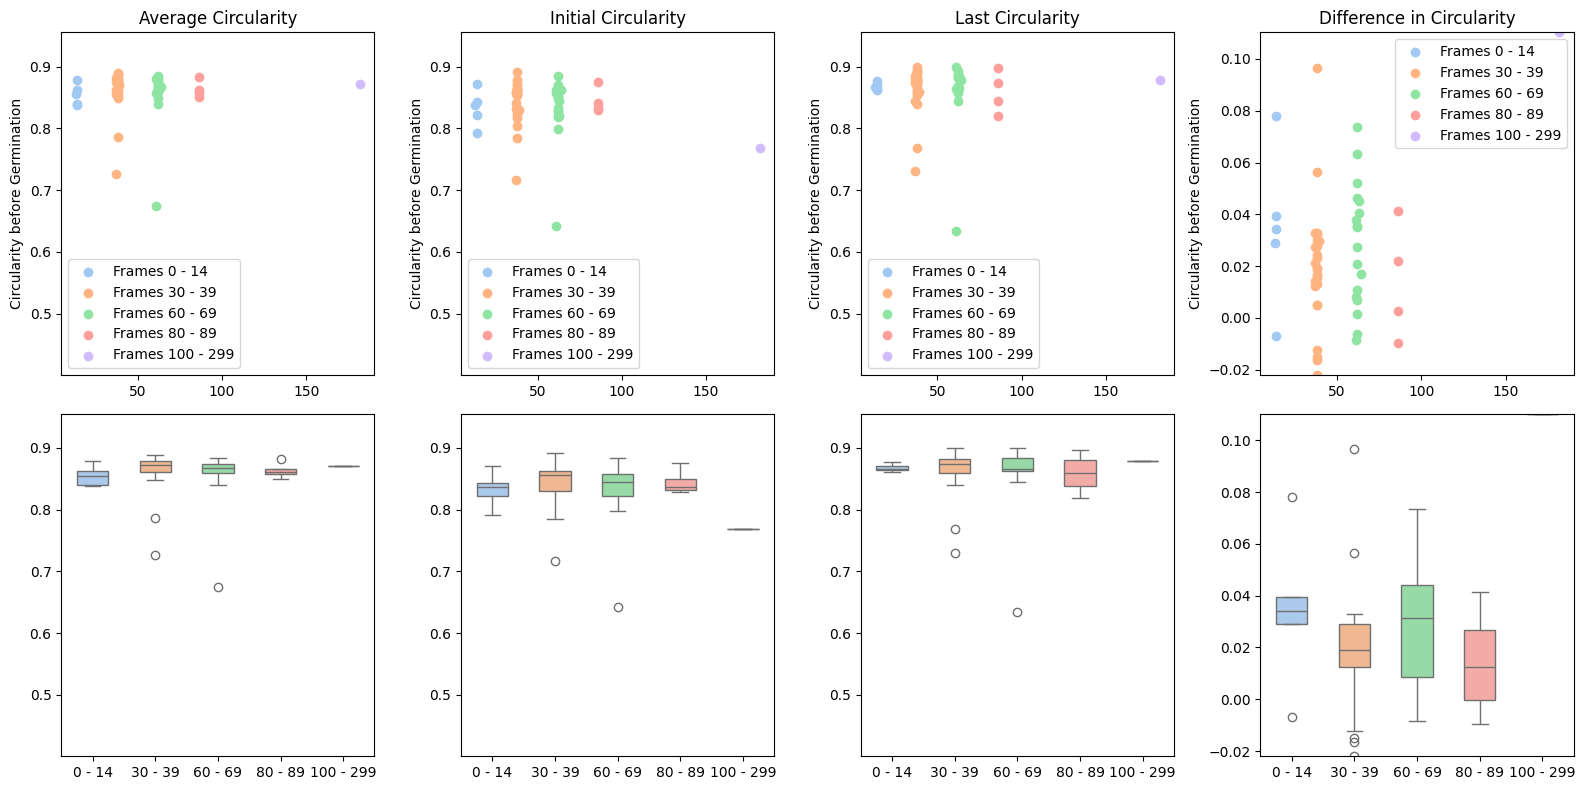

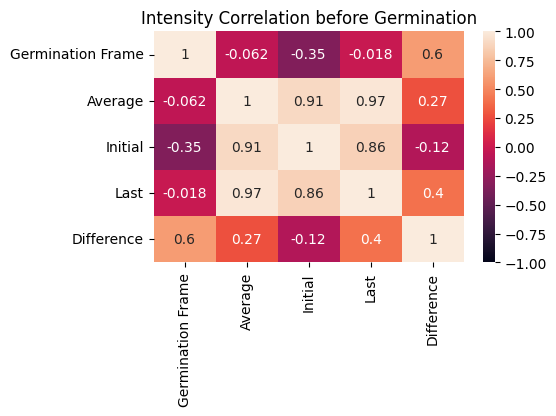

<Figure size 640x480 with 0 Axes>

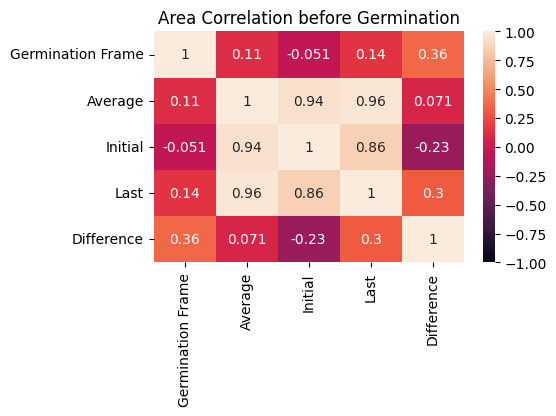

<Figure size 640x480 with 0 Axes>

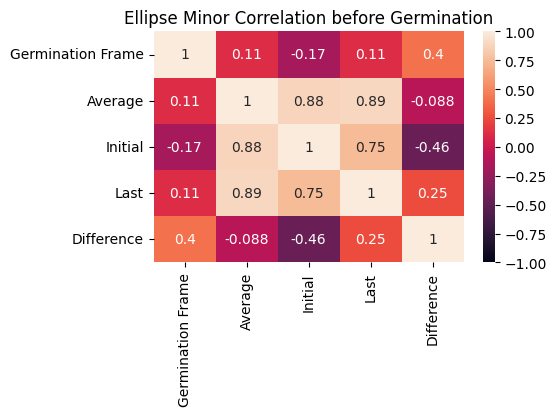

<Figure size 640x480 with 0 Axes>

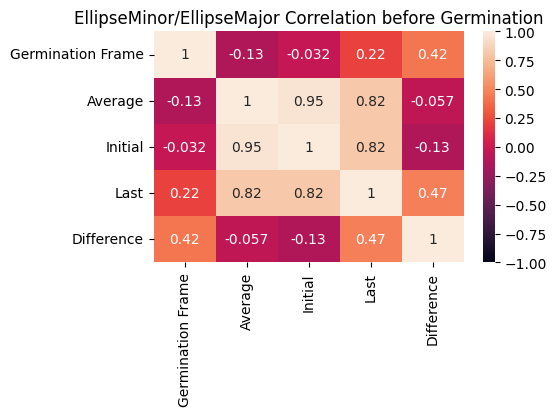

<Figure size 640x480 with 0 Axes>

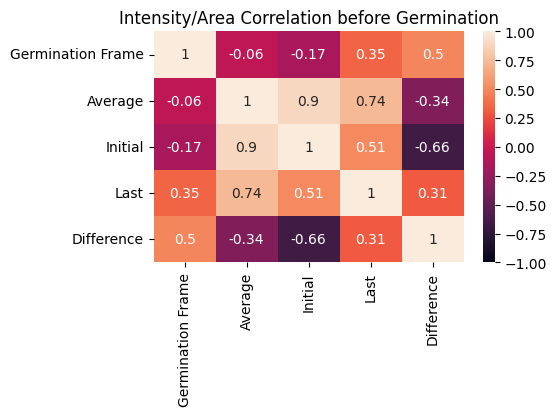

<Figure size 640x480 with 0 Axes>

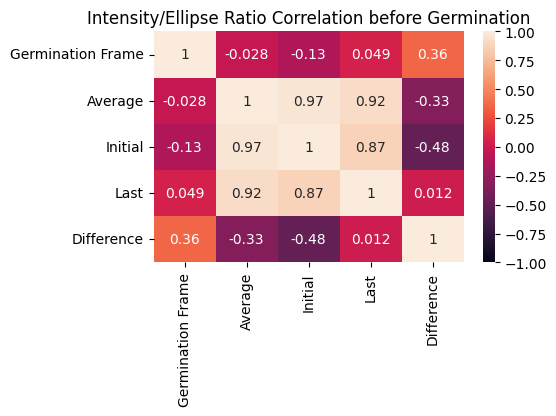

<Figure size 640x480 with 0 Axes>

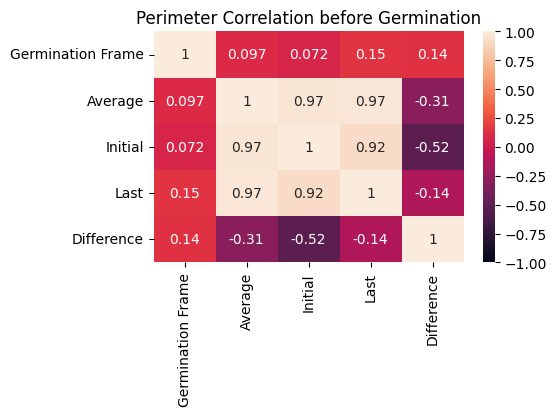

<Figure size 640x480 with 0 Axes>

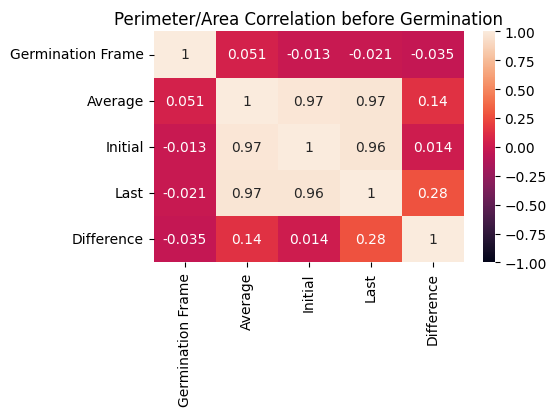

<Figure size 640x480 with 0 Axes>

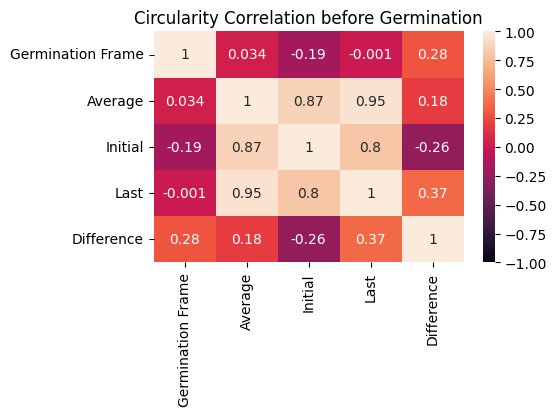

<Figure size 640x480 with 0 Axes>

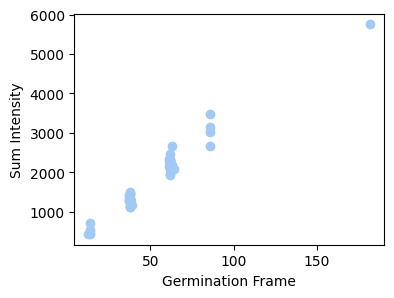

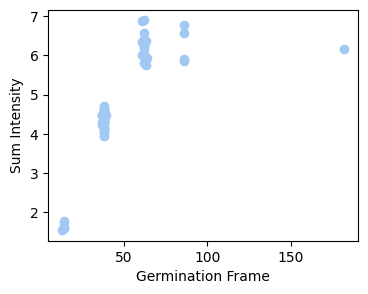

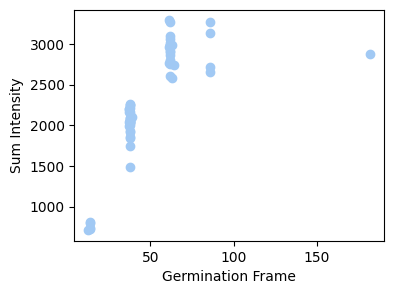

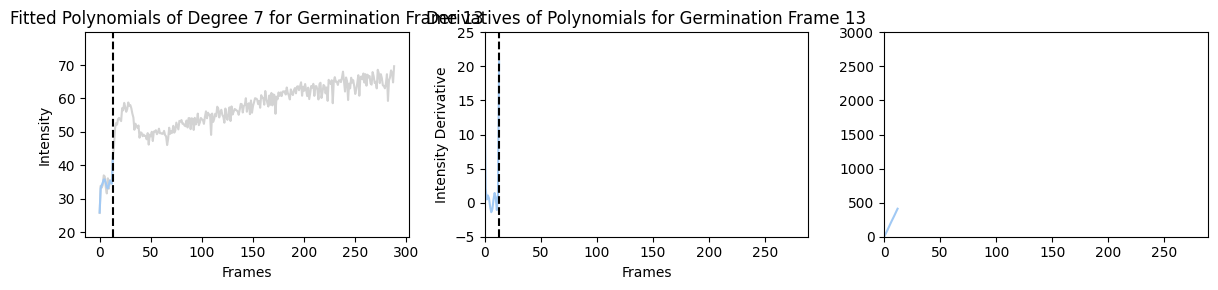

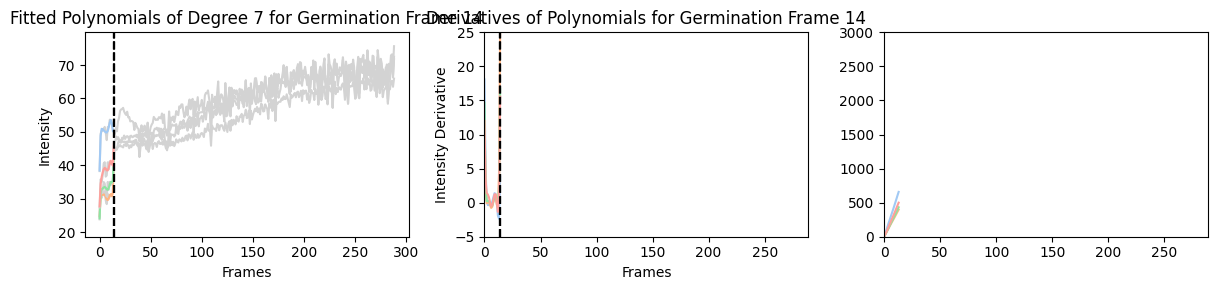

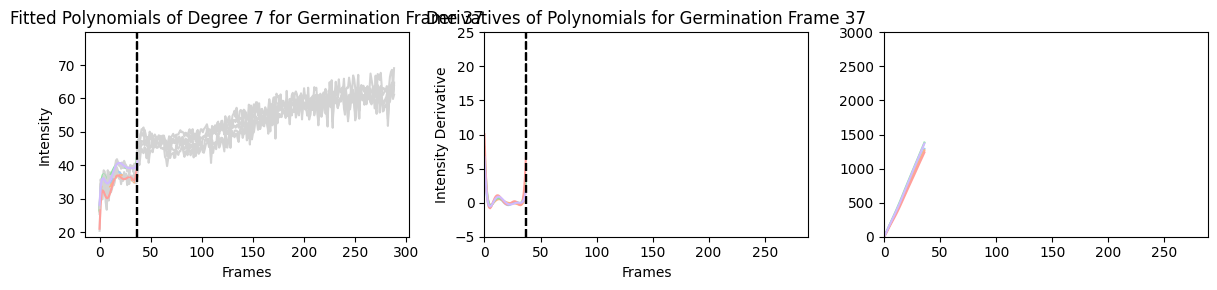

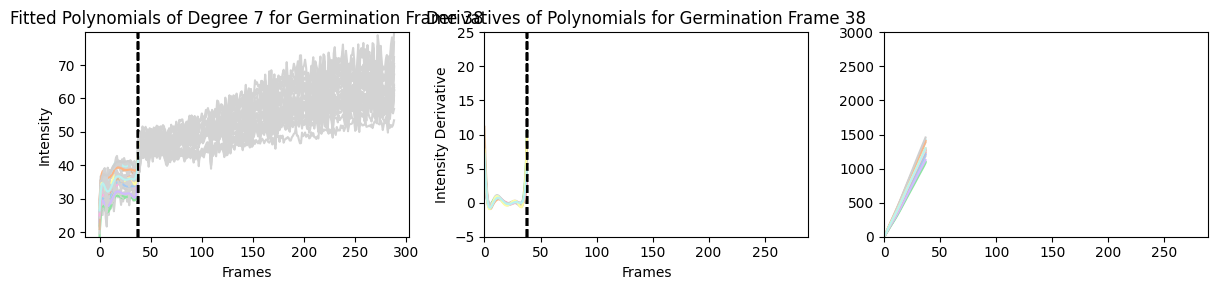

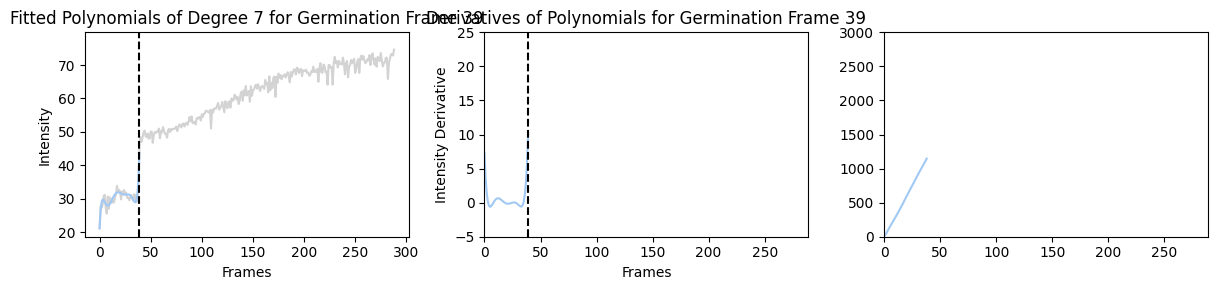

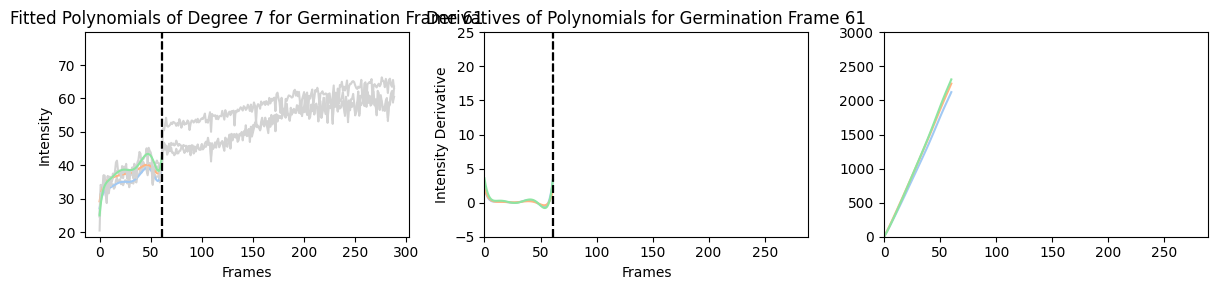

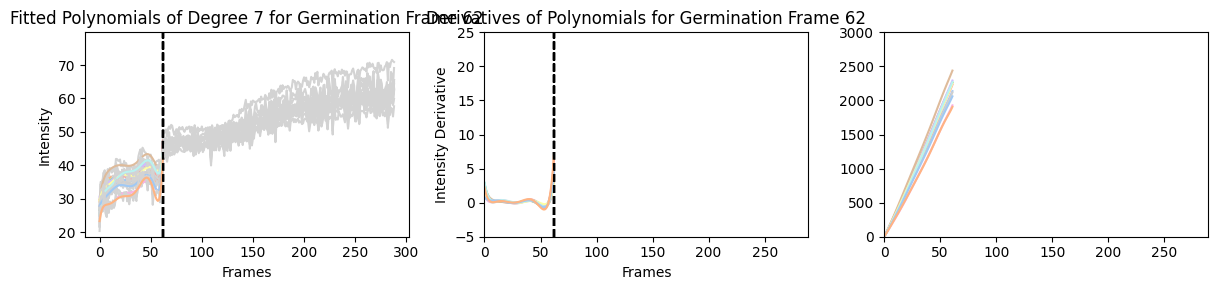

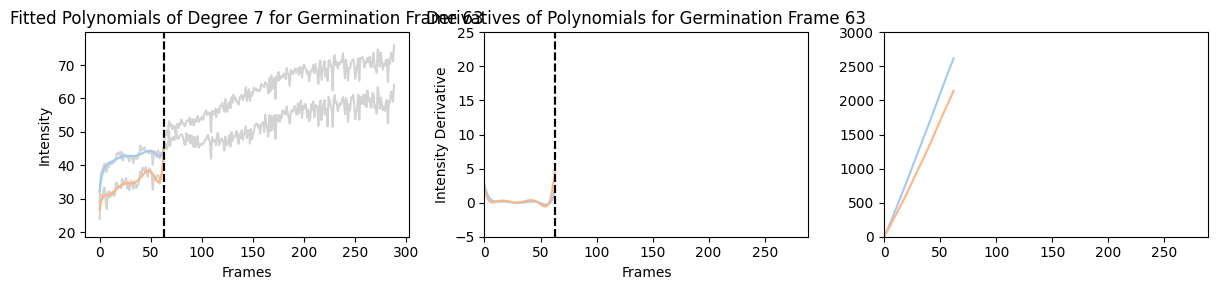

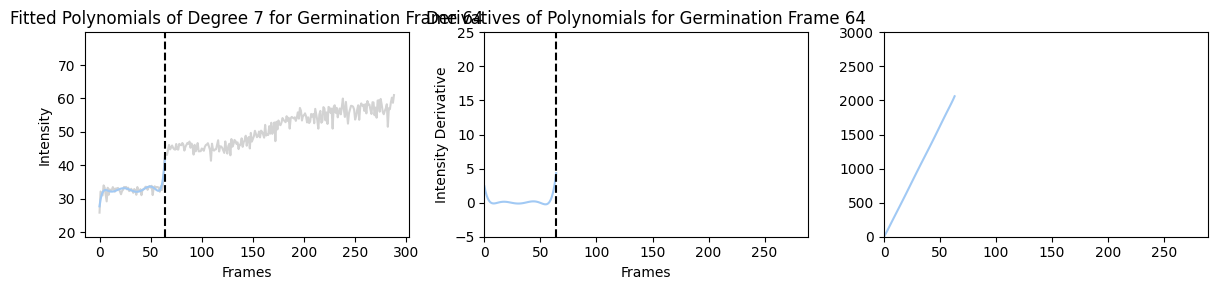

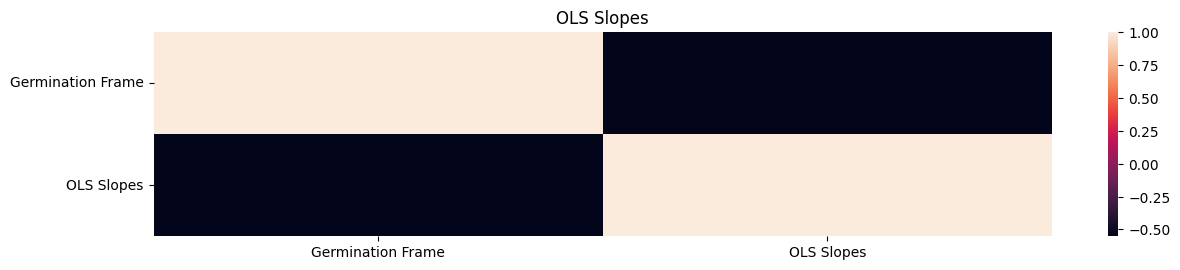

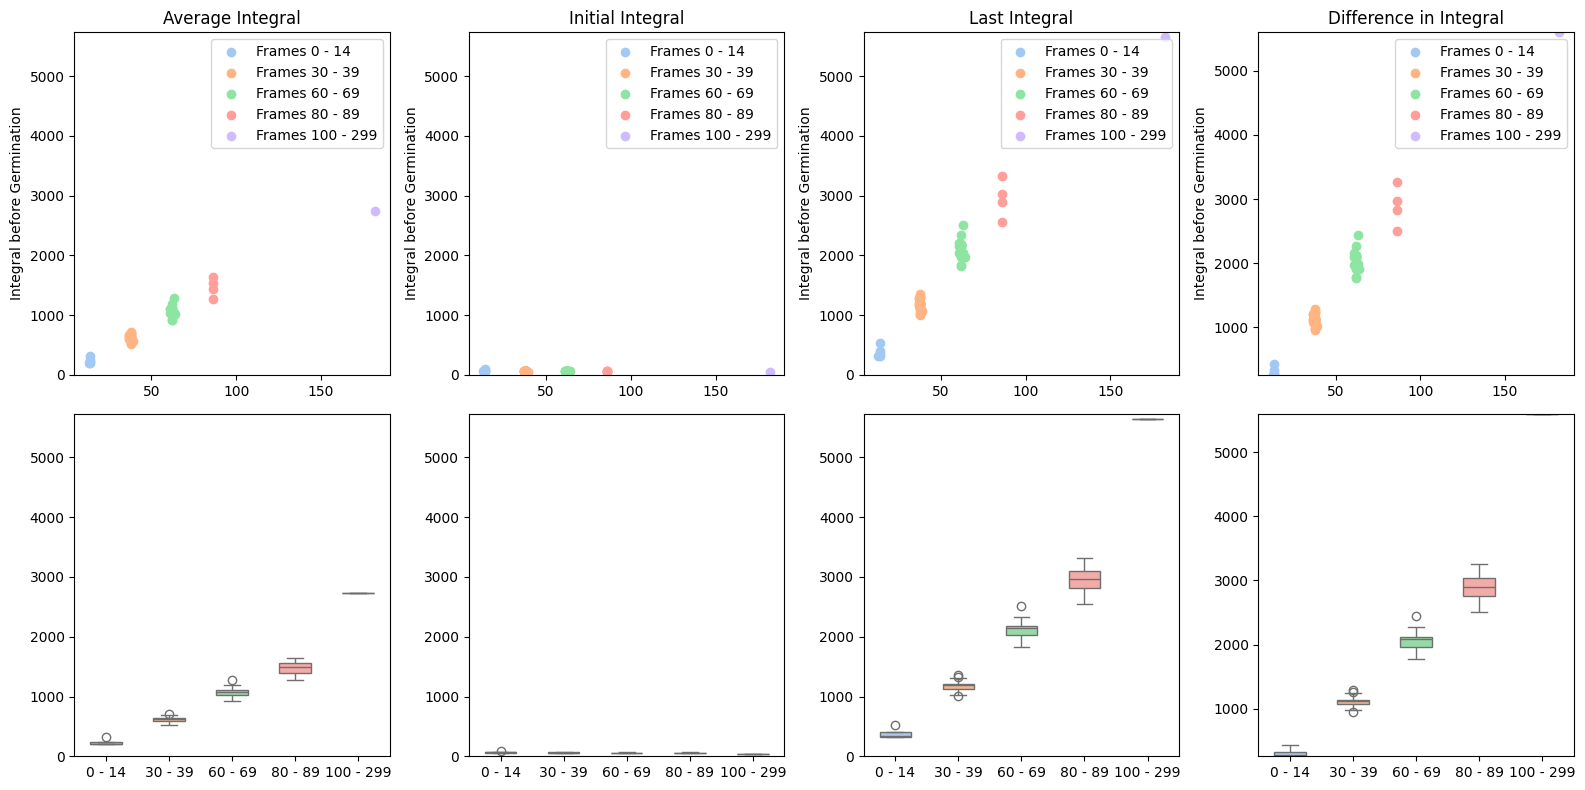

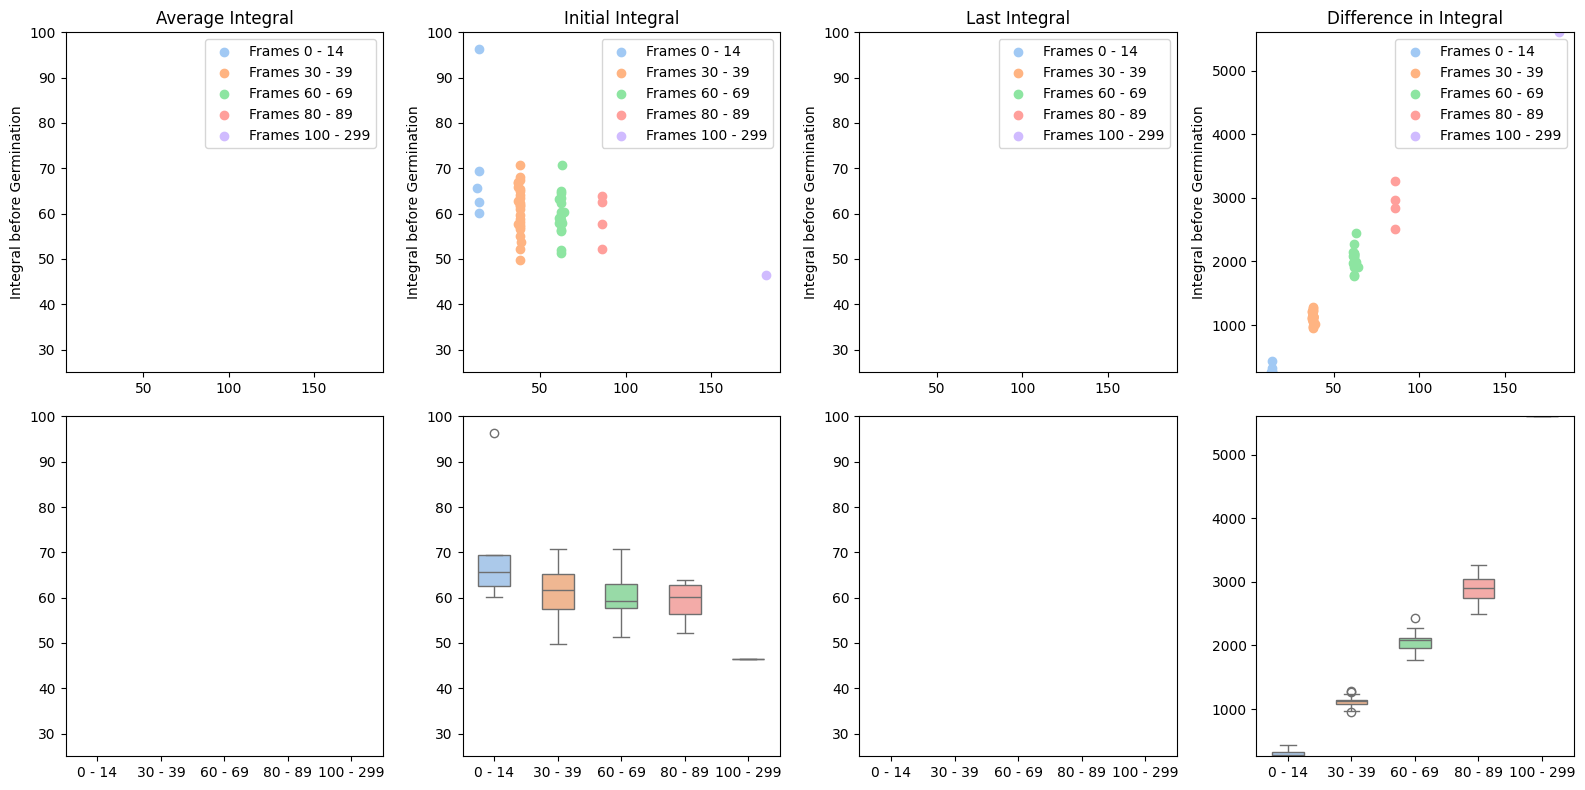

In [3869]:
if __name__ == "__main__":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Plots/"
  time_between_frames = 5

  Main(csv_path, plots_folder, time_between_frames)
            